<a href="https://colab.research.google.com/github/boufik/Google-Colab-Projects/blob/main/100_men_in_prison_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 100 men in prison - The best strategy in the riddle

## Rules

* 100 prisoners numbered from 0-99
* There are also 100 boxes, numbered from 0 to 99 and each one contains a shirt
* Each prisoner may enter the room one at a time and can only check 50/100 boxes
* As soon as one finds their shirt (with the same number), they must leave the room
* In order for them to win and be freed, all must find their shirts

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Construct unique permutations - RUN ONCE

In [29]:
N = 10
LIMIT = N // 2
SIMS = 10**5

In [32]:
import random

def construct_unique_permutations(N, SIMS):
    base = list(range(N))
    unique = set()
    while len(unique) < SIMS:
        copied = base[:]
        random.shuffle(copied)
        perm = tuple(copied)        # Lists are unhashable, tuples can go in sets
        unique.add(perm)            # Sets automatically filter for duplicates (no need for an 'if' statement) --> This line of code does NOTHING if "perm" is already in set --> Size of the set stays unchanged
    return [list(p) for p in unique]

perms = construct_unique_permutations(N, SIMS)
print(f"Just created {SIMS} UNIQUE permutations of boxes-shirts from 0-{N-1}")

Just created 100000 UNIQUE permutations of boxes-shirts from 0-9


# Best strategy

In [33]:
def best_strategy(perms, N, LIMIT):

    SIMS = len(perms)
    wins = 0

    for perm in perms:

        success = True    # Initialization for each perm - Assume success for this perm, unless a player fails
        for player in range(N):
            next_box = player  # Initialization for the next_box

            for attempt in range(LIMIT):
                shirt = perm[next_box]

                if shirt == player:
                    # If this "player" found their shirt --> break this inner loop --> continue with the outer loop and the next "player"
                    break
                else:
                    # Go to the next box indicated by the number found
                    next_box = shirt
            else:
                # If player used all attempts without success
                success = False
                break  # This round failed, move to next permutation

        if success:
            wins += 1

    perc100 = wins / SIMS * 100
    print(f"{80*'~'}\nSimulations (unique permutations) ran: {SIMS}\n{N} players from 0 to {N-1} with {LIMIT} attempts to find their shirts\nWin percentage: {perc100:.4}%\n{80*'~'}\n\n")
    return wins, perc100

wins, perc100 = best_strategy(perms, N, LIMIT)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Simulations (unique permutations) ran: 100000
10 players from 0 to 9 with 5 attempts to find their shirts
Win percentage: 35.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




# Custom Strategy 1

Since the pronouncement says "As soon as one prisoner finds their shirt (with the same number), they must leave the room", we can suppose that they have the idea of timing (**a simple timer is needed**).


We can map the prisoner's **success box** with their **leave time**. This way, the prisoners can communicate events, in this case in which box the next ones should NOT search inside and waste their attempts!

If the prisoner finds their shirt inside the 27th box they checked, then they must leave the room exactly after 27 minutes (we map each attempt with 1 minute, but in real-life. prisoners could use a lower value of mapping).

So, if the prisoner leaves the room after 27 minutes (going towards the 28th minute), the other prisoners understand that his shirt was inside the 27th box he searched and they will NOT include it during their attempts. **It is just a hint for the next ones to NOT search in this box!**

So, the next prisoners do NOT include the boxes which the previous ones found their respective shirts and increase their probability of finding theirs.

***Note: In any strategy, if the first half of the prisoners succeed, it is guaranteed that also the next ones will succeed (if LIMIT = N // 2)***


For 10 prisoners, the possibiility of success is:

P_suc = 5/10 * 5/9 * 5/8 * 5/7 * 5/6 = 10.33%

In [34]:
def custom_strategy1(perms, N, LIMIT, details=False):

    SIMS = len(perms)
    wins = 0

    for perm in perms:

        if details:
            print(perm)
        success = True
        boxes_available = perm[:]    # Copy the "perm" variable

        # I need to check only the first half partition of the prisoners
        for player in range(N // 2):
            check = boxes_available[:LIMIT]
            if details:
                print(f"Player {player} must check this 'perm' partition: {check}")
            if player in check:
                if details:
                    print(f"Player {player} FOUND their shirt!")
                boxes_available.remove(player)
            else:
                # Even if a single player does NOT find their shirt --> the whole "perm" is considered as an unsuccessful one --> "break" and proceed with the next unique "perm"
                if details:
                    print(f"Player {player} did NOT find their shirt!\nExitting this 'perm' simulation...\n")
                success = False
                break

        if success:
            if details:
                print("This 'perm' was successful!!!\n")
            wins += 1

    perc100 = wins / SIMS * 100
    print(f"{80*'~'}\nSimulations (unique permutations) ran: {SIMS}\n{N} players from 0 to {N-1} with {LIMIT} attempts to find their shirts\nWin percentage: {perc100:.4}%\n{80*'~'}\n\n")
    return wins, perc100

wins_1, perc100_1 = custom_strategy1(perms, N, LIMIT, details=False)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Simulations (unique permutations) ran: 100000
10 players from 0 to 9 with 5 attempts to find their shirts
Win percentage: 10.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




# Custom Strategy 2

In the previous custom strategy, prisoners achieved to "encode" only 1 kind of information: the box inside which their shirt was. If one left the room with the shirts after 27 minutes, it signified that his shirt was inside the 27th box he searched, so the remaining prisoners knew where NOT to search.

But now, we can come with a better strategy and communicate more info/events. A prisoner can inform the NEXT one if one of the boxes he previously searched (before finding his own one) contained his (NEXT) shirt. So, the next one can either search in the previous boxes and find his shirt with 100% probability if the current player "notifies" him to do so, or delete them from his searching options and go for the remaining ones.

How to do this? Now, if a player finds his shirt, but has also found the shirt of the next one in the previous boxes he searched, he can now leave with a 0.5 minutes delay from the time he would originally leave.

**Example: If prisoner 5 finds his shirt in the 27th box he searched, but he has also found the shirt with number 6 (next player's) inside the previous 26 boxes, he now has to leave after 27.5 minutes. If he leaves after 27 minutes, this means that the previous 26 boxes did NOT contain the shirt with number 6**.

So, a comprehensive "matrix":

* **Leaves after 1 minute (exactly)**: *The other prisoners will NOT search in the 1st box this player searched*
* **Leaves after x minutes**: *The other prisoners know that they should NOT search in the x-th box the current player searched, but the next player is also notified to NOT search in the previous x-1 boxes*
* **Leaves after x+0.5 minutes**: *The other prisoners know that they should NOT search in the x-th box the current player searched, but the next player is also notified to SEARCH in the previous x-1 boxes as his shirt is inside one of them*
* **Leaves after LIMIT minutes**: *This player was lucky to find his shirt in his last attempt, but the time of his leave does NOT hint the next player if he has met his shirt inside the previous LIMIT-1 boxes*

In [35]:
def custom_strategy2(perms, N, LIMIT, details=False):

    SIMS = len(perms)
    wins = 0

    for perm in perms:
        if details:
            print(f"{80*'~'}\n{perm}\n")
        success = True

        boxes = perm[:]    # Copy the permutation
        indeces_found = list()    # Will bed used to exclude from search ("check")
        indeces_NO_search = list()    # Will be used to exclude from search ("check")

        for player in range(N // 2):

            # If-case for where to "check" - Do NOT search in the "forbidden" indices
            forbidden_indeces = set(indeces_found + indeces_NO_search)
            forbidden_indeces = sorted(list(forbidden_indeces))
            remaining_indeces = [i for i in range(N) if i not in forbidden_indeces]

            counter = 0
            check = list()

            for rem in remaining_indeces:
                counter += 1
                check.append(boxes[rem])
                if counter == LIMIT:
                    break

            if details:
                print(f"\n----> Player {player}:\nperm = {perm}\nForbidden items:")
                for forb in forbidden_indeces:
                    print(f"{perm[forb]},  ", end=" ")
                print(f"\nPlayer {player} must check this 'perm' partition: {check}")


            if player in check:
                if details:
                    print(f"Player {player} FOUND his shirt!")
                check_ind_found = check.index(player)
                ind_found = boxes.index(player)     # Relative to the original "boxes" permutation and not the temporary "check" list
                indeces_found.append(ind_found)

                if player+1 in check[:check_ind_found]:
                    # If the player has ALSO found the next one's shirt in this partition until the point he search (:ind_found) and NOT in ALL the parition he could check
                    if details:
                        print(f"Player {player} ALSO FOUND shirt '{player+1}' of the next prisoner while searching !!!")
                        indeces_NO_search = list()      # Reset this list, no restrictions for the next person

                else:
                    if details:
                        print(f"Player {player} has NOT found shirt '{player+1}' of the next prisoner while searching !!!")
                        # We must exclude from the next search all these boxes
                        # Example: if ind_found = 2 (starting index = 0), then the NEXT prisoner should NOT search in the positions ind_found-1 and ind_found-2
                        indeces_NO_search += list(range(ind_found-1,-1,-1))

            else:
                # Even if a single player does NOT find their shirt --> the whole "perm" is considered as an unsuccessful one --> "break" and proceed with the next unique "perm"
                if details:
                    print(f"Player {player} did NOT find his shirt!\nExitting this 'perm' simulation...\n")
                    success = False
                    break

        if success:
            if details:
                print("This 'perm' was successful!!!\n")
            wins += 1

    perc100 = wins / SIMS * 100
    print(f"{80*'~'}\nSimulations (unique permutations) ran: {SIMS}\n{N} players from 0 to {N-1} with {LIMIT} attempts to find their shirts\nWin percentage: {perc100:.4}%\n{80*'~'}\n\n")
    return wins, perc100

wins_2, perc100_2 = custom_strategy2(perms, N, LIMIT, details=False)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Simulations (unique permutations) ran: 100000
10 players from 0 to 9 with 5 attempts to find their shirts
Win percentage: 100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




## Statistics

In [36]:
def pretty_diagramme(bars, y, N):
    # Adding labels inside the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2,  # position inside bar
                f'{height:.2f}%', ha='center', va='center', fontsize=12, color='black')

    plt.ylabel('Success Rate (%)')
    plt.title(f"Strategies - Success Rates Comparison for {N} prisoners")
    plt.xticks(rotation=15)
    plt.ylim(0, max(y) * 1.1)
    plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                           Success_Rate (%)
Expected_By_Best_Strategy            30.690
Best_Strategy                        35.365
Custom_Strategy_1                    10.292
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




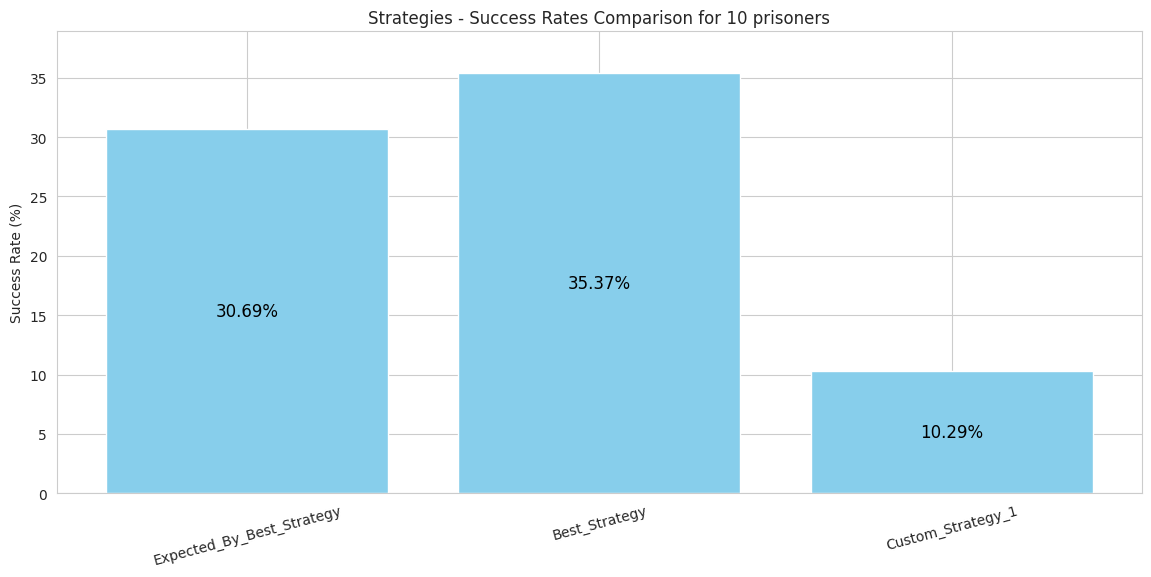

In [37]:
import math
expected = round(100 * (1 - math.log(N/LIMIT)), 2)
success_rate = [expected, perc100, perc100_1]
ids = ['Expected_By_Best_Strategy', 'Best_Strategy', 'Custom_Strategy_1']
df = pd.DataFrame({'Success_Rate (%)': success_rate}, index=ids)
print(f"{60*'~'}\n{df}\n{60*'~'}\n\n")

y = list(df['Success_Rate (%)'])
plt.figure(figsize=(14, 6))
bars = plt.bar(ids, y, color='skyblue')
pretty_diagramme(bars, y, N)

# TESTING

In [38]:
perms = [[8, 3, 1, 4, 0, 6, 2, 7, 9, 5]]

def custom_strategy2(perms, N, LIMIT, details=False):

    SIMS = len(perms)
    wins = 0

    for perm in perms:
        if details:
            print(f"{80*'~'}\n{perm}\n")
        success = True

        boxes = perm[:]    # Copy the permutation
        indeces_found = list()    # Will be used to exclude from search ("check")
        banned_values_from_check = list()

        for player in range(N // 2):

            # If-case for where to "check" - Do NOT search in the "forbidden" indices
            forbidden_indeces = sorted(indeces_found)
            forbidden_values = [perm[ii] for ii in forbidden_indeces]
            banned_values = banned_values_from_check + forbidden_values
            banned_values = list(set(banned_values))
            remaining_values = [num for num in range(N) if num not in banned_values]
            check = remaining_values[:LIMIT]

            if details:
                print(f"\n----> Player {player}:\nperm = {perm}\nForbidden items:")
                for forb in forbidden_indeces:
                    print(f"{perm[forb]},  ", end=" ")
                print(f"\nPlayer {player} must check this 'perm' partition: {check}")

            if player in check:
                if details:
                    print(f"Player {player} FOUND his shirt!")
                check_ind_found = check.index(player)
                ind_found = boxes.index(player)     # Relative to the original "boxes" permutation and not the temporary "check" list
                indeces_found.append(ind_found)

                if player+1 in check[:check_ind_found]:
                    # If the player has ALSO found the next one's shirt in this partition until the point he search (:ind_found) and NOT in ALL the parition he could check
                    if details:
                        print(f"Player {player} ALSO FOUND shirt '{player+1}' of the next prisoner while searching !!!")
                        banned_values_from_check = []

                else:
                    if details:
                        print(f"Player {player} has NOT found shirt '{player+1}' of the next prisoner while searching !!!")
                        # We must exclude from the next search all these boxes
                        # Example: if ind_found = 2 (starting index = 0), then the NEXT prisoner should NOT search in the positions ind_found-1 and ind_found-2
                        banned_values_from_check = check[:check_ind_found]

            else:
                # Even if a single player does NOT find their shirt --> the whole "perm" is considered as an unsuccessful one --> "break" and proceed with the next unique "perm"
                if details:
                    print(f"Player {player} did NOT find his shirt!\nExitting this 'perm' simulation...\n")
                    success = False
                    break

        if success:
            if details:
                print("This 'perm' was successful!!!\n")
            wins += 1

    perc100 = wins / SIMS * 100
    print(f"{80*'~'}\nSimulations (unique permutations) ran: {SIMS}\n{N} players from 0 to {N-1} with {LIMIT} attempts to find their shirts\nWin percentage: {perc100:.4}%\n{80*'~'}\n\n")
    return wins, perc100

wins_2, perc100_2 = custom_strategy2(perms, N, LIMIT, details=True)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[8, 3, 1, 4, 0, 6, 2, 7, 9, 5]


----> Player 0:
perm = [8, 3, 1, 4, 0, 6, 2, 7, 9, 5]
Forbidden items:

Player 0 must check this 'perm' partition: [0, 1, 2, 3, 4]
Player 0 FOUND his shirt!
Player 0 has NOT found shirt '1' of the next prisoner while searching !!!

----> Player 1:
perm = [8, 3, 1, 4, 0, 6, 2, 7, 9, 5]
Forbidden items:
0,   
Player 1 must check this 'perm' partition: [1, 2, 3, 4, 5]
Player 1 FOUND his shirt!
Player 1 has NOT found shirt '2' of the next prisoner while searching !!!

----> Player 2:
perm = [8, 3, 1, 4, 0, 6, 2, 7, 9, 5]
Forbidden items:
1,   0,   
Player 2 must check this 'perm' partition: [2, 3, 4, 5, 6]
Player 2 FOUND his shirt!
Player 2 has NOT found shirt '3' of the next prisoner while searching !!!

----> Player 3:
perm = [8, 3, 1, 4, 0, 6, 2, 7, 9, 5]
Forbidden items:
1,   0,   2,   
Player 3 must check this 'perm' partition: [3, 4, 5, 6, 7]
Player 3 FOUND his shirt!
Pla